In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [2]:
root_directory = 'Semantic segmentation dataset/'

patch_size = 256

In [3]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print("Path:", path)  
    dirname = path.split(os.path.sep)[-1] # just directory name
    #print("Dir name:", dirname)
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)   

                # here, have a large resized image          
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 1\images/image_part_009.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 2\images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/T

In [4]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_004.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_005.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_006.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_007.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_008.png
Now patchifying mask: Semantic segmentation dataset/Tile 1\masks/image_part_009.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Tile 2\masks/image_part_

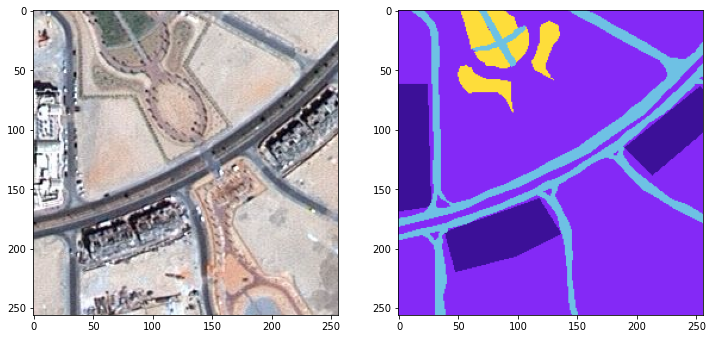

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

To appreciate this, let us look at patchify in detail:

In [6]:
image = cv2.imread("Semantic segmentation dataset\\Tile 1\\images\\"+"image_part_001.jpg", 1)  #Read each image as BGR
SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
image = Image.fromarray(image)
image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
image = np.array(image) 

patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

patchedArray = []     
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        
        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
        patchedArray.append(single_patch_img)

In [7]:
len(patchedArray)

6

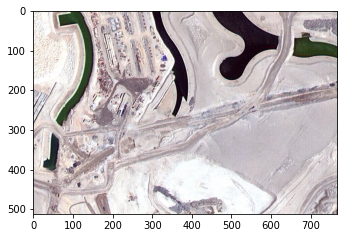

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image)
plt.show()

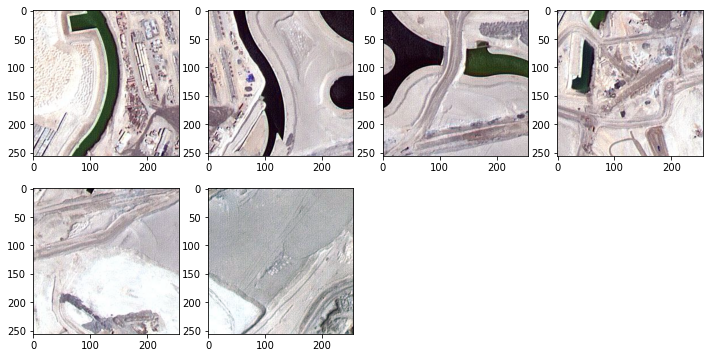

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(241)
plt.imshow(np.reshape(patchedArray[0], (patch_size, patch_size, 3)))
plt.subplot(242)
plt.imshow(np.reshape(patchedArray[1], (patch_size, patch_size, 3)))
plt.subplot(243)
plt.imshow(np.reshape(patchedArray[2], (patch_size, patch_size, 3)))
plt.subplot(244)
plt.imshow(np.reshape(patchedArray[3], (patch_size, patch_size, 3)))
plt.subplot(245)
plt.imshow(np.reshape(patchedArray[4], (patch_size, patch_size, 3)))
plt.subplot(246)
plt.imshow(np.reshape(patchedArray[5], (patch_size, patch_size, 3)))
plt.show()

As we can see - the code is cutting the image into smaller pieces!

So, we clearly have a collection of images and their corresponding masks!

The code below uses information provided by the data-set about the respective mask colours

In [10]:
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [11]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg
###

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [13]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


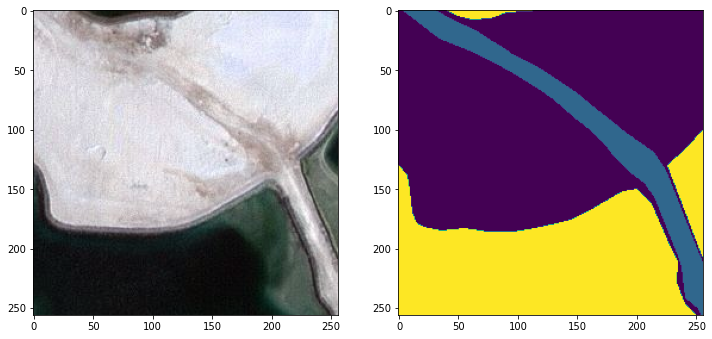

In [14]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

All that we have done there is replaced the values of the pixels with our labels!

In [15]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [16]:
#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

In [17]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

Before going further - double check that CUDA setup!

In [18]:
# import tensorflow as tf
# print(tf.__version__)
# print(tf.config.list_physical_devices('GPU'))
# print(tf.test.is_built_with_cuda())


In [19]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [20]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [21]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100


: 

: 